In [1]:
# Base

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot settings

%matplotlib inline
sns.set_context('talk')
sns.set_palette('gray')
sns.set_style('ticks', {'grid.color' : '0.9'})

In [3]:
# Feature engineering

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import TransformerMixin

In [4]:
# Algorithms

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

In [5]:
# Model selection

from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [6]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Brief summary of the non-obvious features: 
- `Pclass` is the class of the ticket purchased by the passenger
- `SibSp` is the number of siblings/spouses aboard for the passenger 
- `Parch` is the number of parents/children aboard for the passenger  
- `Ticket` is the ticket number
- `Embarked` is the port of embarkation

In [8]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The above two summaries show that there are missing values. We look at where these missings are concentrated

In [10]:
total_na = train_df.isnull().sum().sort_values(ascending=False)
percent_na = (total_na*100/len(train_df)).round(2).sort_values(ascending=False)

missing_stats = pd.concat([total_na, percent_na], axis = 1, keys = ['Total', '%'])

In [11]:
missing_stats.sort_values(by = 'Total', ascending=False).head(5)

,Total,%
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Name,0,0.00


This preliminary inspection shows that we might be better off dropping `Cabin`

We begin by looking at the distribution of the outcome `Survived` and each of the features. This will help us decide if any transformations are necessary. Usually, this develops an intuition for each of the features. It is possible to plot several interactions between the variables, but the intuition from a plot might not scale to a model. From my perspective, distribution of each individual feature is a more vital intuition rather than the interactions.

In [12]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

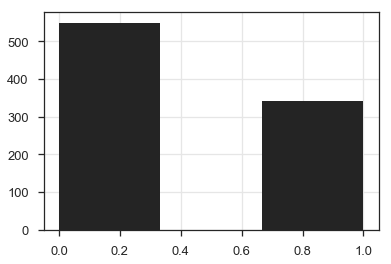

In [13]:
train_df['Survived'].hist(bins = 3)

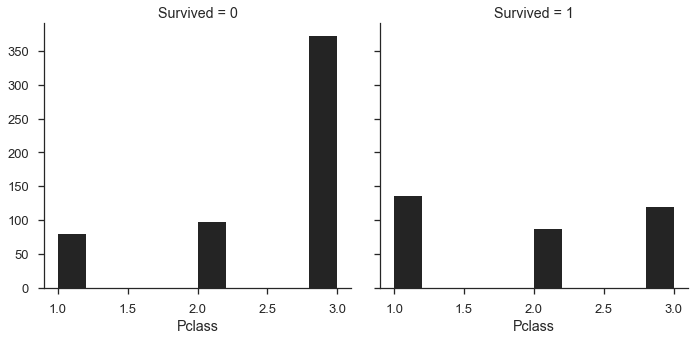

In [14]:
sns.FacetGrid(train_df, col = 'Survived', size = 5).map(plt.hist, 'Pclass')

TypeError: '<' not supported between instances of 'str' and 'float'

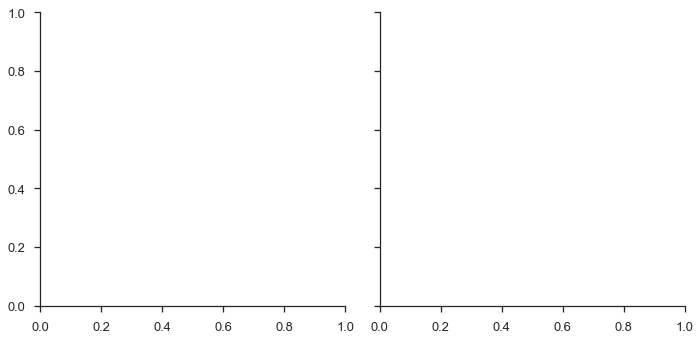

In [19]:
sns.FacetGrid(train_df, col = 'Survived', size = 5).map(plt.hist, 'Sex')

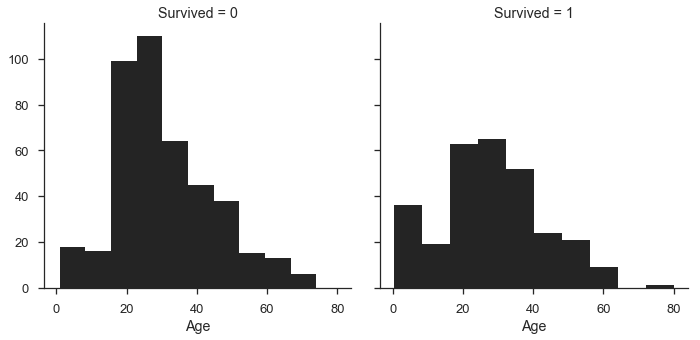

In [17]:
sns.FacetGrid(train_df, col = 'Survived', size = 5).map(plt.hist, 'Age')

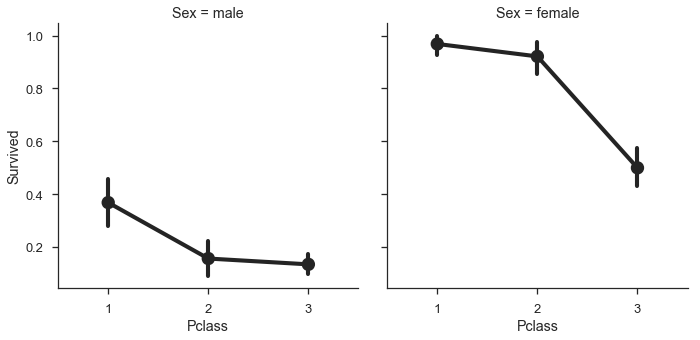

In [20]:
sns.factorplot(x = 'Pclass', y = 'Survived', col = 'Sex', data = train_df, size = 5)

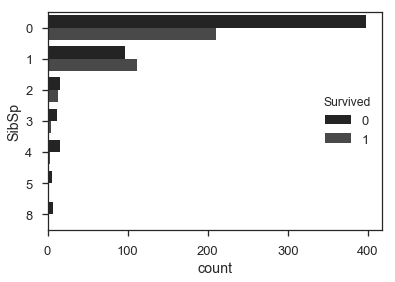

In [21]:
sns.countplot(y = 'SibSp', hue = 'Survived', data = train_df)

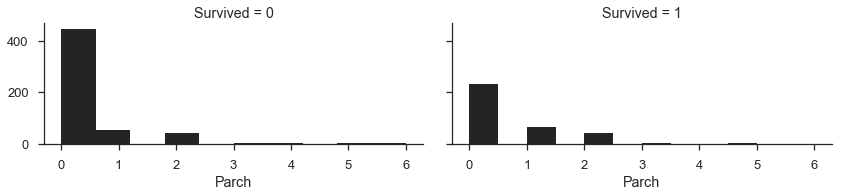

In [22]:
sns.FacetGrid(train_df, col = 'Survived', size = 3, aspect = 2).map(plt.hist, 'Parch')

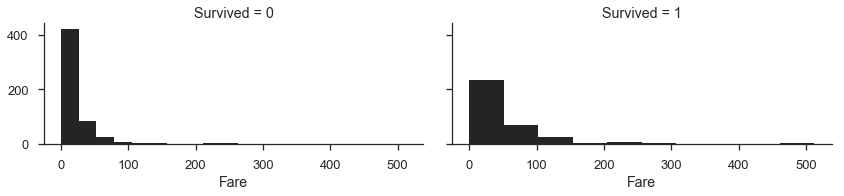

In [23]:
sns.FacetGrid(train_df, col = 'Survived', size = 3, aspect = 2).map(plt.hist, 'Fare')

TypeError: '<' not supported between instances of 'str' and 'float'

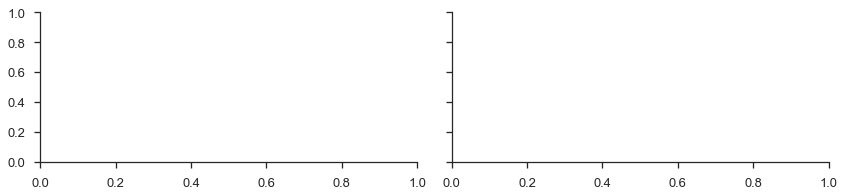

In [24]:
sns.FacetGrid(train_df, col = 'Survived', size = 3, aspect = 2).map(plt.hist, 'Embarked')

In [25]:
test_df.columns.values

array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [26]:
train = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

In [27]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [28]:
x_train_df = train.drop('Survived', axis = 1)
y_train = train['Survived']

In [29]:
x_train_df.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [30]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [31]:
x_train_df = DataFrameImputer().fit_transform(x_train_df)

In [32]:
x_train_df.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [33]:
x_train_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [34]:
x_train_df = pd.get_dummies(x_train_df)

In [35]:
x_train_df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [36]:
std_scaler = StandardScaler()

In [37]:
x_train = std_scaler.fit_transform(x_train_df)

Now, our training data is transformed and scaled into all numeric features. It is time to apply models in succession. We are trying to get a sense of accuracy of all the models and shortlist 2-3 models at this stage

In [38]:
sgd_classif = SGDClassifier(max_iter=1000, tol=1e-3)

In [39]:
sgd_score = cross_val_score(sgd_classif, x_train, y_train,
                            scoring = 'accuracy',
                            cv = 10)

In [40]:
rf_classif = RandomForestClassifier(n_estimators = 100, 
                                    random_state=20130810)

In [41]:
rf_score = cross_val_score(rf_classif, x_train, y_train,
                           scoring = 'accuracy', 
                           cv = 10)

In [42]:
logit_classif = LogisticRegression()

In [43]:
logit_score = cross_val_score(logit_classif, x_train, y_train,
                              scoring = 'accuracy',
                              cv = 10)

In [44]:
knn5_classif = KNeighborsClassifier(n_neighbors = 5)

In [45]:
knn5_score = cross_val_score(knn5_classif, x_train, y_train,
                             scoring = 'accuracy',
                             cv = 10)

In [46]:
nb_classif = GaussianNB()

In [47]:
nb_score = cross_val_score(nb_classif, x_train, y_train,
                           scoring = 'accuracy',
                           cv = 10)

In [48]:
perceptron_classif = Perceptron()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [49]:
perceptron_score = cross_val_score(perceptron_classif, x_train, y_train,
                                   scoring = 'accuracy',
                                   cv = 10)

In [50]:
linearsvc_classif = LinearSVC()

In [66]:
linearSVC_score = cross_val_score(linearsvc_classif, x_train, y_train, 
                                  scoring = 'accuracy', 
                                  cv = 10)

In [52]:
svc_classif = SVC()

In [53]:
svc_score = cross_val_score(svc_classif, x_train, y_train,
                            scoring = 'accuracy',
                            cv = 10)

In [54]:
dtree_classif = DecisionTreeClassifier()

In [55]:
dtree_score = cross_val_score(dtree_classif, x_train, y_train,
                              scoring = 'accuracy',
                              cv = 10)

In [68]:
results = pd.DataFrame({ 'Model' : ['Decision Tree', 'SVC', 'Linear SVC', 'Perceptron', 'Naive Bayes', \
                                    '5NN', 'Logistic Regression', 'Random Forests', 'SGD'] ,
                         'Accuracy_mean' : [dtree_score.mean(), svc_score.mean(), linearSVC_score.mean(), \
                                            perceptron_score.mean(), nb_score.mean(), knn5_score.mean(), \
                                            logit_score.mean(), rf_score.mean(), sgd_score.mean()],
                         'Accuracy_sd' : [dtree_score.std(), svc_score.std(), linearSVC_score.std(), \
                                            perceptron_score.std(), nb_score.std(), knn5_score.std(), \
                                            logit_score.std(), rf_score.std(), sgd_score.std()]})

In [82]:
scores = np.concatenate((dtree_score, svc_score, linearSVC_score, perceptron_score, nb_score, knn5_score,\
                         logit_score, rf_score, sgd_score), axis = 0)

In [91]:
algorithms = [np.repeat(algo, 10) for algo in ['Decision Tree', 'SVC', 'Linear SVC', 'Perceptron', 'Naive Bayes', \
                                               '5NN', 'Logistic Regression', 'Random Forests', 'SGD']]

In [92]:
algorithms = np.array(algorithms).flatten()

In [113]:
results_df = pd.DataFrame({ 'Model' : algorithms , 'Accuracy' : scores })

In [111]:
results_df.head()

,Accuracy,Model
0,0.700000,Decision Tree
1,0.777778,Decision Tree
2,0.730337,Decision Tree
3,0.786517,Decision Tree
4,0.820225,Decision Tree


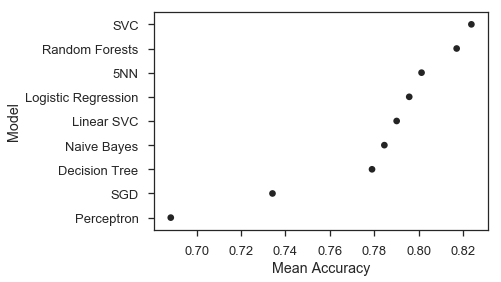

In [114]:
sns.pointplot(y = 'Model', x = 'Accuracy_mean',
              data = results.sort_values(by = 'Accuracy_mean', ascending = False),
              scale = 0.5,
              join = False)
plt.xlabel("Mean Accuracy");

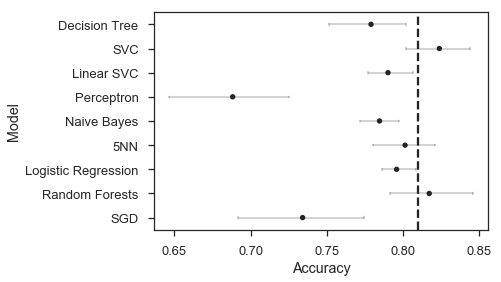

In [131]:
sns.pointplot(y = 'Model', x = 'Accuracy', 
              data = results_df,
              scale = 0.4,              
              errwidth = 0.4,
              capsize = 0.1,
              join = False)
plt.axvline(x = 0.81, linestyle = '--')

Looks like Random Forests and SVC are the best bet even without tuning. So, lets tune the forests.

In [132]:
pgrid = {'criterion' : ['gini', 'entropy'],
         'min_samples_leaf' : [1, 10, 20, 50],
         'min_samples_split' : [2, 10, 20, 30],
         'n_estimators' : [100, 500, 1000]}

In [133]:
rf_classif = RandomForestClassifier(n_estimators = 100,
                                    max_features = 'auto',
                                    oob_score = True,
                                    random_state = 20130810,
                                    n_jobs = -1)

In [134]:
rf_cv = RandomizedSearchCV(estimator=rf_classif,
                           param_distributions = pgrid,
                           n_iter = 25,
                           n_jobs = -1)

In [135]:
%time
rf_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=20130810, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 10, 20, 50], 'min_samples_split': [2, 10, 20, 30], 'n_estimators': [100, 500, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [136]:
rf_cv.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}

In [137]:
rf_classif = RandomForestClassifier(n_estimators = 500,
                                    max_features = 'auto',
                                    criterion = 'gini',
                                    min_samples_leaf = 1,
                                    min_samples_split = 10,
                                    oob_score = True,
                                    random_state = 20130810,
                                    n_jobs = -1)

In [138]:
rf_classif.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=20130810, verbose=0,
            warm_start=False)